<a href="https://colab.research.google.com/github/UtwoA/Introduction_to_ML/blob/main/ml2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [19]:
class MGUA_Regressor:

    def __init__(self, depth=6, keep_ratio=0.65, patience=2):
        self.depth = depth
        self.keep_ratio = keep_ratio
        self.patience = patience
        self.history = []
        self.final_models = []
        self.scaler = StandardScaler()

    def _train_pair(self, Xp, y, reg=0.0003):
        mdl = Ridge(alpha=reg)
        mdl.fit(Xp, y)
        w = np.hstack([mdl.intercept_, mdl.coef_])
        return w

    def _predict(self, Xp, w):
        return w[0] + Xp @ w[1:]

    def fit(self, X_train, y_train, X_val, y_val):

        Xtr = self.scaler.fit_transform(X_train)
        Xv = self.scaler.transform(X_val)

        features = list(range(Xtr.shape[1]))
        no_gain = 0
        last_mse = np.inf

        print("Запуск обучения МГУА\n")

        for layer in range(1, self.depth+1):

            pairs = list(combinations(features, 2))
            results = []

            print(f"===== Слой {layer} | признаков: {len(features)} =====")

            for f1, f2 in pairs:
                Xt = Xtr[:, [f1, f2]]
                Xva = Xv[:, [f1, f2]]

                w = self._train_pair(Xt, y_train)
                y_pred = self._predict(Xva, w)
                mse = mean_squared_error(y_val, y_pred)

                results.append((mse, (f1,f2), w))

            results.sort(key=lambda x: x[0])
            top_n = max(2, int(len(results)*self.keep_ratio))
            selected = results[:top_n]

            best_mse = selected[0][0]
            print(f"Лучшая MSE слоя: {best_mse:.6f}")

            if best_mse > last_mse:
                print("Ошибка выросла - остановка")
                break
            else:
                improvement = abs(last_mse - best_mse)
                last_mse = best_mse

                if improvement < 0.0001:
                    no_gain += 1
                else:
                    no_gain = 0

                if no_gain >= self.patience:
                    print("Прогресс минимален - остановка")
                    break

            new_tr, new_val = [], []
            for mse_fit, (a,b), w in selected:
                new_tr.append(self._predict(Xtr[:,[a,b]], w))
                new_val.append(self._predict(Xv[:,[a,b]], w))

            Xtr = np.array(new_tr).T
            Xv = np.array(new_val).T
            features = list(range(Xtr.shape[1]))

            self.final_models.append(selected[0])

        print("\nОбучение завершено.")

    # прогноз
    def predict(self, X):
        X = self.scaler.transform(X)
        best = self.final_models[-1]
        (f1,f2), w = best[1], best[2]
        return self._predict(X[:,[f1,f2]], w)

In [20]:
data = [
    [0.904,75.5,25.2,3343,77],
    [0.922,78.5,21.8,3001,78.2],
    [0.763,78.4,25.7,3101,68],
    [0.923,77.7,17.8,3543,77.2],
    [0.918,84.4,15.9,3237,77.2],
    [0.906,75.9,22.4,3330,77.2],
    [0.905,76,20.6,3808,75.7],
    [0.545,67.5,25.2,2415,62.6],
    [0.894,78.2,20.7,3295,78],
    [0.9,78.1,17.5,3504,78.2],
    [0.932,78.6,19.7,30565,79],
    [0.74,84,18.5,3007,67.6],
    [0.701,59.2,54.4,2844,69.8],
    [0.744,90.2,23,2861,68.4],
    [0.921,72.8,20.2,3259,77.9],
    [0.927,67.7,25.2,3350,78.1],
    [0.802,82.6,22.4,3344,72.5],
    [0.747,74.4,22.7,2704,66.6],
    [0.927,83.3,18.1,3642,76.7],
    [0.721,83.7,20.1,2753,68.8],
    [0.913,73.8,17.3,2916,76.8],
    [0.918,79.2,16.8,3551,78.1],
    [0.833,71.5,29.9,3177,73.9],
    [0.914,75.3,20.3,3280,78.6],
    [0.923,79,14.1,3160,78.5]
]

df = pd.DataFrame(data, columns=['y','f1','f2','f3','f4'])

In [21]:
train = df.iloc[:20]
test = df.iloc[20:]

In [22]:
Xtr = train[['f1','f2','f3','f4']].values
ytr = train['y'].values
Xv = train.iloc[12:][['f1','f2','f3','f4']].values
yv = train.iloc[12:]['y'].values
X_test = test[['f1','f2','f3','f4']].values
y_test = test['y'].values

In [23]:
model = MGUA_Regressor(depth=6, keep_ratio=0.65, patience=2)
model.fit(Xtr, ytr, Xv, yv)

y_pred = model.predict(X_test)

Запуск обучения МГУА

===== Слой 1 | признаков: 4 =====
Лучшая MSE слоя: 0.000491
===== Слой 2 | признаков: 3 =====
Лучшая MSE слоя: 0.000504
Ошибка выросла - остановка

Обучение завершено.


In [24]:
print("\nРезультаты на тесте")
print("MSE =", mean_squared_error(y_test,y_pred))
print("MAE =", mean_absolute_error(y_test,y_pred))
print("R^2  =", r2_score(y_test,y_pred))



Результаты на тесте
MSE = 0.0002711758035742982
MAE = 0.014516371783528381
R^2  = 0.7624099288793214


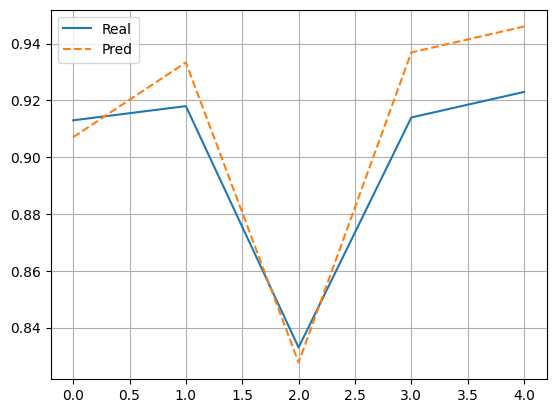

In [25]:
plt.plot(y_test,label="Real")
plt.plot(y_pred,label="Pred",linestyle="--")
plt.legend()
plt.grid()
plt.show()